<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">


---

# **Análise Exploratória de Dados de Logística**

## 1\. Contexto

Projeto de Análise Exploratória, completo, de informações logísticas da Startup Loggi, geração de visualizações gráficas e retirada de insights sobre a situação no Distrito Federal.

## 2\. Pacotes e bibliotecas

In [1]:
# instalando e importando todas as  bibliotecas utilizadas

!pip3 install geopandas

import json

import pandas as pd
import numpy as np
import geopandas
import matplotlib.pyplot as plt
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import seaborn as sns

## 3\. Exploração de dados

In [2]:
#Importando os dados que foram disponíveis pela loggi
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json

with open('deliveries.json', mode='r', encoding='utf8') as file:
    data = json.load(file)

In [3]:
# colocando o dado bruto em um dataframe do pandas
deliveries_df = pd.DataFrame(data)

# Separando os itens contidos no "origin" para ficar mais facil a utilização e a visulização
hub_origin_df = pd.json_normalize(deliveries_df['origin'])
deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)
deliveries_df = deliveries_df.drop('origin', axis=1)
deliveries_df = deliveries_df[['name', 'region', 'lng', 'lat', 'vehicle_capacity', 'deliveries']]
deliveries_df.rename(columns={'lng': 'hub_lng', 'lat': 'hub_lat'}, inplace=True)

#Fazendo o mesmo procedimento com o "deliveries"
deliveries_exploded_df = deliveries_df[['deliveries']].explode('deliveries')
deliveries_normalized_df = pd.concat([
    pd.DataFrame(deliveries_exploded_df['deliveries'].apply(lambda record: record['id'])).rename(columns={'deliveries': 'delivery_id'}),
    pd.DataFrame(deliveries_exploded_df['deliveries'].apply(lambda record: record['size'])).rename(columns={'deliveries': 'delivery_size'}),
    pd.DataFrame(deliveries_exploded_df['deliveries'].apply(lambda record: record['point']['lng'])).rename(columns={'deliveries': 'delivery_lng'}),
    pd.DataFrame(deliveries_exploded_df['deliveries'].apply(lambda record: record['point']['lat'])).rename(columns={'deliveries': 'delivery_lat'}),
], axis=1)
deliveries_df = deliveries_df.drop('deliveries', axis=1)
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)

deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_id,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,313483a19d2f8d65cd5024c8d215cfbd,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,320c94b17aa685c939b3f3244c3099de,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,3663b42f4b8decb33059febaba46d5c8,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,e11ab58363c38d6abc90d5fba87b7d7,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,54cb45b7bbbd4e34e7150900f92d7f4b,7,-48.114898,-15.858055


3.1 Conferência dos dados

In [4]:
# conferindo se os tipos correspondem ao desejado
deliveries_df.dtypes

name                 object
region               object
hub_lng             float64
hub_lat             float64
vehicle_capacity      int64
delivery_id          object
delivery_size         int64
delivery_lng        float64
delivery_lat        float64
dtype: object

In [5]:
# conferindo se a contagem bate em relação aos 3 itens
deliveries_df.select_dtypes('object').describe().transpose()

,count,unique,top,freq
name,636149,199,cvrp-1-df-87,5636
region,636149,3,df-1,304708
delivery_id,636149,291566,61b87669243974d021c2b76fc5272045,12


In [6]:
#Conferindo se há valores nulos
deliveries_df.isna().any()

name                False
region              False
hub_lng             False
hub_lat             False
vehicle_capacity    False
delivery_id         False
delivery_size       False
delivery_lng        False
delivery_lat        False
dtype: bool

## 4\. Manipulação

4.1 Enriquecimento de dados

In [7]:
#Criando outro dataframe para enriquecer os dados disponíveis com o 'geopandas'
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]]
hub_df = hub_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)
hub_df.head()


,region,hub_lng,hub_lat
0,df-0,-47.802665,-15.657014
1,df-1,-47.893662,-15.805118
2,df-2,-48.054989,-15.838145


In [8]:
geolocator = Nominatim(user_agent="ebac_geocoder")

In [9]:
#colocando um limitador para não extrapolar o tempo mínimo que o 'Nominatim' pede
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

In [10]:
#obtendo as informações a partir das coordenadas
hub_df["coordinates"] = hub_df["hub_lat"].astype(str)  + ", " + hub_df["hub_lng"].astype(str)
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)
hub_df.head()

,region,hub_lng,hub_lat,coordinates,geodata
0,df-0,-47.802665,-15.657014,"-15.657013854445248, -47.802664728268745","(Rua 7, Quadra 2, Sobradinho, Região Geográfic..."
1,df-1,-47.893662,-15.805118,"-15.80511751066334, -47.89366206897872","(SQS 303, Asa Sul, Brasília, Plano Piloto, Reg..."
2,df-2,-48.054989,-15.838145,"-15.83814451122274, -48.05498915846707","(Armazém do Bolo, lote 4/8, CSB 4/5, Taguating..."


In [11]:
#quebrando cada 'geodata' para utilizarmos somente os necessário
hub_geodata_df = pd.json_normalize(hub_df['geodata'].apply(lambda data: data.raw))
hub_geodata_df.head()

,place_id,licence,osm_type,osm_id,lat,lon,class,type,place_rank,importance,...,address.state,address.ISO3166-2-lvl4,address.region,address.postcode,address.country,address.country_code,address.neighbourhood,address.city,address.shop,address.house_number
0,46410411,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,240210480,-15.656916027876347,-47.80264463632131,highway,secondary,26,0.10001,...,Distrito Federal,BR-DF,Região Centro-Oeste,73015-202,Brasil,br,NaN,NaN,NaN,NaN
1,46401425,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,66353368,-15.805172757199022,-47.893723539491205,highway,residential,26,0.10001,...,Distrito Federal,BR-DF,Região Centro-Oeste,70342-010,Brasil,br,SQS 303,Brasília,NaN,NaN
2,43777060,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6249717596,-15.8384371,-48.0552917,shop,pastry,30,0.00001,...,Distrito Federal,BR-DF,Região Centro-Oeste,72015-030,Brasil,br,NaN,Taguatinga,Armazém do Bolo,lote 4/8


In [12]:
#obtendo a cidade e o suburbio de cada hub
hub_geodata_df = hub_geodata_df[['address.town', 'address.suburb', 'address.city']]
hub_geodata_df.rename(columns={'address.town': 'hub_town', 'address.suburb': 'hub_suburb', 'address.city': 'hub_city'}, inplace=True)
hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)
hub_geodata_df.head()

,hub_suburb,hub_city
0,Sobradinho,Sobradinho
1,Asa Sul,Brasília
2,Taguatinga,Taguatinga


In [13]:
#Mesclando com o dataframe hub_df
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[['region', 'hub_suburb', 'hub_city']]
hub_df.head()

,region,hub_suburb,hub_city
0,df-0,Sobradinho,Sobradinho
1,df-1,Asa Sul,Brasília
2,df-2,Taguatinga,Taguatinga


In [14]:
#mesclando com o dataframe principal
deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how='inner', on='region')
deliveries_df = deliveries_df[['name', 'region', 'hub_lng', 'hub_lat', 'hub_city', 'hub_suburb', 'vehicle_capacity', 'delivery_id', 'delivery_size', 'delivery_lng', 'delivery_lat']]
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_id,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,313483a19d2f8d65cd5024c8d215cfbd,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,320c94b17aa685c939b3f3244c3099de,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,3663b42f4b8decb33059febaba46d5c8,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,e11ab58363c38d6abc90d5fba87b7d7,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,54cb45b7bbbd4e34e7150900f92d7f4b,7,-48.114898,-15.858055


In [15]:
#obtendo os dados das entregas por meio externo já que seriam muitos dados para serem processados e com o limitador de 1 dado por segundo, ficaria inviável fazê-lo
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv

In [16]:
deliveries_geodata_df = pd.read_csv("deliveries-geodata.csv")
deliveries_geodata_df.head()

,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,-48.116189,-15.848929,Ceilândia,P Sul
1,-48.118195,-15.850772,Ceilândia,P Sul
2,-48.112483,-15.847871,Ceilândia,P Sul
3,-48.118023,-15.846471,Ceilândia,P Sul
4,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [17]:
#mesclando os dados obtidos com o dataframe principal
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_id,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,313483a19d2f8d65cd5024c8d215cfbd,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,320c94b17aa685c939b3f3244c3099de,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,3663b42f4b8decb33059febaba46d5c8,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,e11ab58363c38d6abc90d5fba87b7d7,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,54cb45b7bbbd4e34e7150900f92d7f4b,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


 4.2 Conferência dos dados obtidos

In [18]:
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   hub_city          636149 non-null  object 
 5   hub_suburb        636149 non-null  object 
 6   vehicle_capacity  636149 non-null  int64  
 7   delivery_id       636149 non-null  object 
 8   delivery_size     636149 non-null  int64  
 9   delivery_lng      636149 non-null  float64
 10  delivery_lat      636149 non-null  float64
 11  delivery_city     634447 non-null  object 
 12  delivery_suburb   476264 non-null  object 
dtypes: float64(4), int64(2), object(7)
memory usage: 63.1+ MB


In [19]:
deliveries_df.isna().any()

name                False
region              False
hub_lng             False
hub_lat             False
hub_city            False
hub_suburb          False
vehicle_capacity    False
delivery_id         False
delivery_size       False
delivery_lng        False
delivery_lat        False
delivery_city        True
delivery_suburb      True
dtype: bool

Como percebe-se que tanto no delivery_city como no delivey_suburb tem itens nulos, vamos conferir o quão significativo são esses valores.

In [20]:
100 * (deliveries_df["delivery_city"].isna().sum() / len(deliveries_df))

0.26754738276724477

In [21]:
100 * (deliveries_df["delivery_suburb"].isna().sum() / len(deliveries_df))

25.133262804783158

Os valores nulos são menores de 1% no caso das cidades, já no caso dos suburbios passam de 25%, sendo um valor bastante elevado.

In [22]:
prop_df = deliveries_df[["delivery_city"]].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

delivery_city       
Brasília                0.234195
Taguatinga              0.071625
Sudoeste / Octogonal    0.069504
Ceilândia               0.059661
Águas Claras            0.058293
Guará                   0.055619
Lago Sul                0.045620
Sobradinho              0.045412
Lago Norte              0.040832
Gama                    0.034880
Name: count, dtype: float64

In [23]:
prop_df = deliveries_df[["delivery_suburb"]].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

delivery_suburb 
Brasília            0.084564
Asa Norte           0.076639
Taguatinga          0.063363
Asa Sul             0.059263
Águas Claras        0.056598
Guará               0.055619
Samambaia           0.026514
Sobradinho          0.018148
Recanto das Emas    0.015029
P Sul               0.012807
Name: count, dtype: float64

Podemos ver também que as cidades teem uma com mais de 23% dos casos, 'Brasília', como esse termo não é uma cidade, é provavel que os locais grafados como 'Brasília' estão locados em áreas rurais.

## 5\. Visualização

5.1 Mapa de distribuição

In [24]:
#obtendo os dados para o mapa no IBGE
!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

In [25]:
mapa = geopandas.read_file('distrito-federal.shp')
mapa = mapa.loc[[0]]
mapa.head()

,geometry
0,"POLYGON Z ((-47.31048 -16.03602 0.00000, -47.3..."


Mapa dos HUBs

In [26]:
hub_df = deliveries_df[['region', 'hub_lng', 'hub_lat']].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df['hub_lng'], hub_df['hub_lat']))
geo_hub_df.head()

,region,hub_lng,hub_lat,geometry
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)


Mapa das entregas

In [27]:
geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df['delivery_lng'], deliveries_df['delivery_lat']))
geo_deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_id,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,313483a19d2f8d65cd5024c8d215cfbd,9,-48.116189,-15.848929,Ceilândia,P Sul,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,320c94b17aa685c939b3f3244c3099de,2,-48.118195,-15.850772,Ceilândia,P Sul,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,3663b42f4b8decb33059febaba46d5c8,1,-48.112483,-15.847871,Ceilândia,P Sul,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,e11ab58363c38d6abc90d5fba87b7d7,2,-48.118023,-15.846471,Ceilândia,P Sul,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,54cb45b7bbbd4e34e7150900f92d7f4b,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,POINT (-48.11490 -15.85805)


/tmp/ipykernel_20/3843635757.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles:


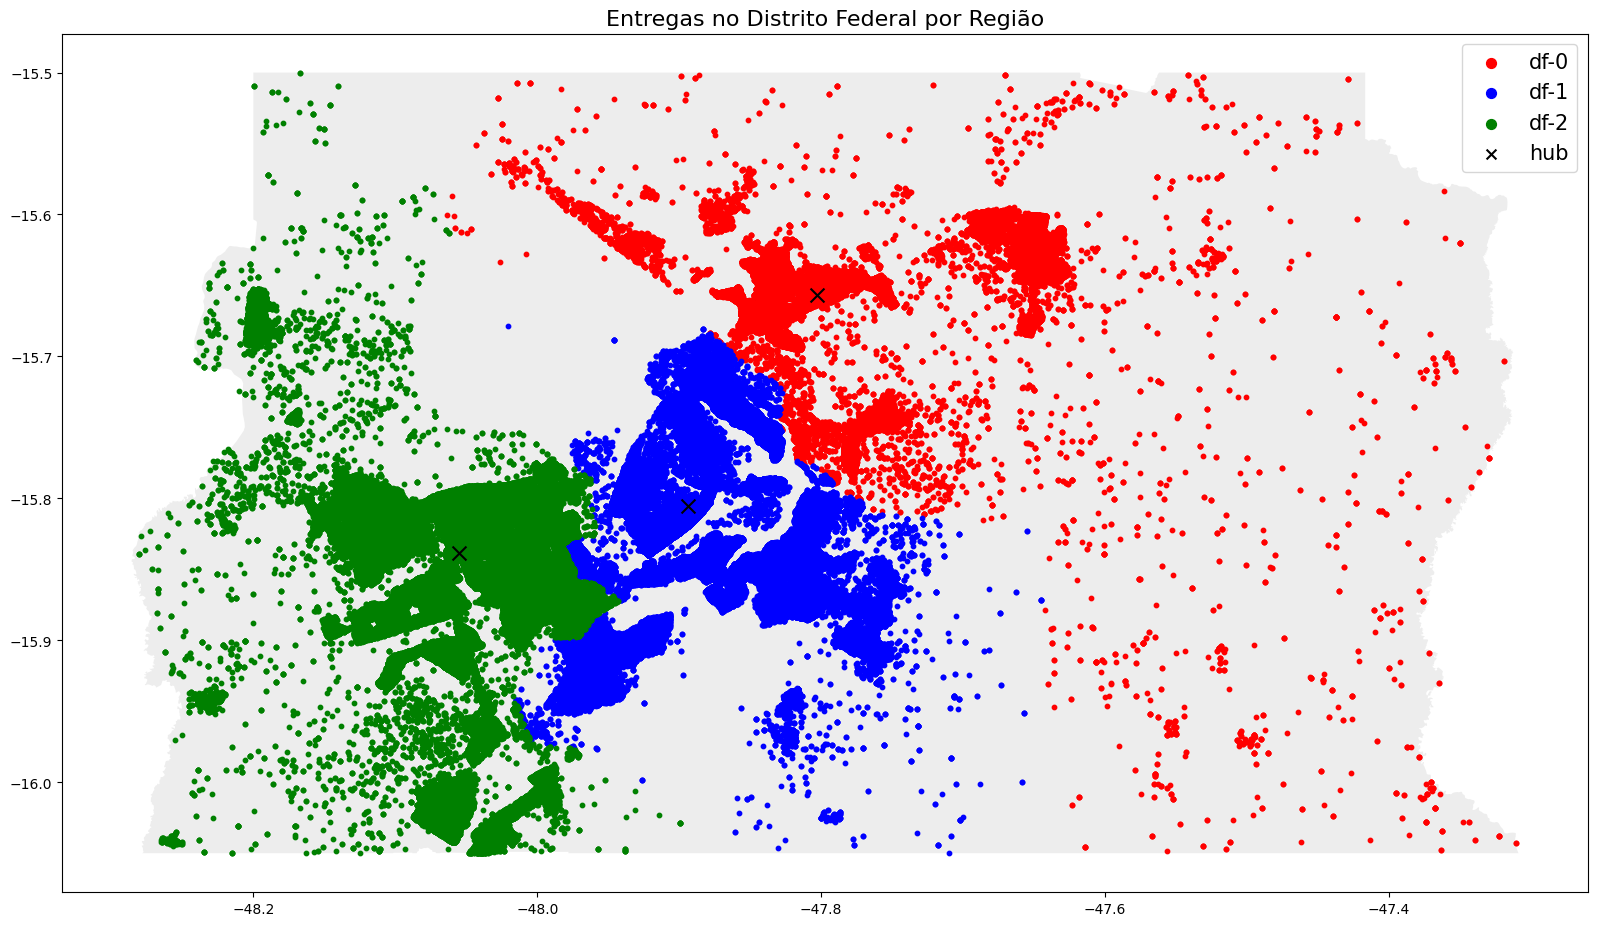

In [28]:
# cria o plot vazio
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

# plot mapa do distrito federal
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

# plot das entregas
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=10, color="red", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=10, color="blue", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=10, color="green", label="df-2")

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=100, marker="x", color="black", label="hub")

# plot da legenda
plt.title("Entregas no Distrito Federal por Região", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legendHandles:
    handle.set_sizes([50])

Pode-se notar que há uma grande conscentração de entregas em poucos locais no df-1.
No df-0 há uma grande dispersão das entregas abrengendo assim a maior área de cobertura.
Já o df-2 é um meio termo dos dois antecedentes, há ma certa conscentração, mas também tem uma certa dispersão.

5.2 Gráfico de Barras

In [29]:
#criando um novo dataframe para o mapa
data = pd.DataFrame(deliveries_df[['region', 'vehicle_capacity']].value_counts(normalize=True)).reset_index()
data.rename(columns={'proportion':'region_percent'}, inplace=True)
data.head()

,region,vehicle_capacity,region_percent
0,df-1,180,0.478988
1,df-2,180,0.410783
2,df-0,180,0.110229


/tmp/ipykernel_20/781639680.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  grafico = sns.barplot(data=data, x= 'region', y= 'region_percent', ci=None, palette=color)


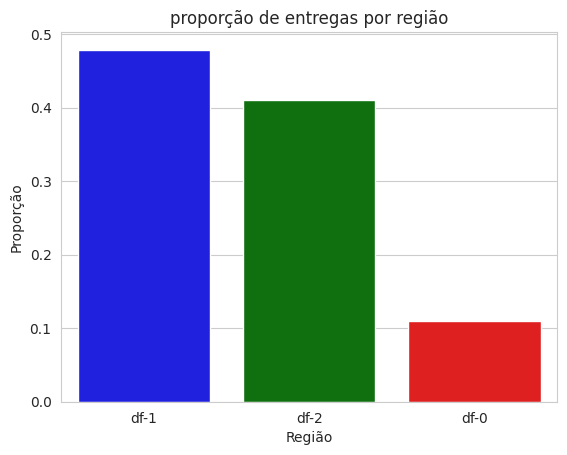

In [30]:
with sns.axes_style('whitegrid'):
  color = ['blue', 'green', 'red']
  grafico = sns.barplot(data=data, x= 'region', y= 'region_percent', ci=None, palette=color)
  grafico.set(title='proporção de entregas por região', xlabel='Região', ylabel='Proporção');

Podemos ver que o df-1, que tem maior conscentrção de entregas por área, também tem a maior porcentagem de entregas, enquanto o df-0, que possui maior abragencia de entregas, corresponde a pouco mias de 10% das entregas totais.

5.3 Gráfico de distribuição das mercadorias

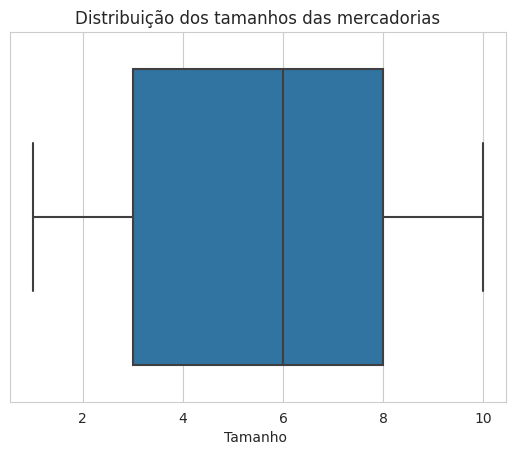

In [31]:
with sns.axes_style('whitegrid'):

    plot = sns.boxplot(x=deliveries_df['delivery_size'])
    plot.set(title='Distribuição dos tamanhos das mercadorias', xlabel='Tamanho ')

Podemos extrair que a mior parte das entregas tem o tamanho entre 3 e 8, com pucas fora desse intervalo, e tendo 6 como tamanho médio das compras.